<div style="background:#0f172a; color:#f9fafb; padding:18px; border-radius:10px; border:1px solid #1e293b;">

<h1 style="margin-top:0; font-size:1.9em;">📊 Comparing Pre-2010, Post-2010, and Synthetic Email Datasets</h1>

<p style="margin-bottom:0;">
This notebook visualizes how three datasets relate to each other in a shared <strong>embedding space</strong>:
</p>

<ul>
  <li><strong>Pre-2010</strong> balanced authentic emails</li>
  <li><strong>Post-2010</strong> balanced authentic emails</li>
  <li><strong>Synthetic</strong> LLM-generated emails</li>
</ul>

<p>
We will:
</p>

<ul>
  <li>Load the balanced CSVs created in <em>Establishing Datasets.ipynb</em>.</li>
  <li>Embed all emails with a <strong>neutral, third-party model</strong> (MPNet).</li>
  <li>Use <strong>t-SNE</strong> to project embeddings to 2D.</li>
  <li>Plot all datasets together and in pairs to study overlap and drift.</li>
</ul>

</div>

<div style="margin-top:10px; padding:12px; border-left:5px solid #3b82f6; background:#eff6ff;">
<strong>Step 0 – Environment & paths</strong><br>
Install the required libraries, mount Google Drive, and define base paths so every later step can load the datasets and save figures.
</div>


In [ ]:
# If you're in Colab, install needed libs
!pip install -q transformers sentence-transformers

import os
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from google.colab import drive
from sentence_transformers import SentenceTransformer  # NEW

drive.mount("/content/drive")

# === Single source of truth for all project paths ===
PROJECT_ROOT = "/content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/"

# Datasets folder (used everywhere in this notebook)
DATA_DIR = os.path.join(PROJECT_ROOT, "Datasets/")
MODEL_DIR = os.path.join(DATA_DIR, "Models")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("MODEL_DIR:", MODEL_DIR)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_DIR: /content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/
MODEL_DIR: /content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/Models


<h2 style="border-bottom:3px solid #22c55e; padding-bottom:4px;">
🎲 Step 1 – Fix random seed for reproducible plots
</h2>

<p>
We fix a global <code>SEED</code> so that:
</p>

<ul>
  <li>Any random sampling of emails is repeatable.</li>
  <li>PyTorch and NumPy behave deterministically where possible.</li>
  <li>t-SNE initialization and sampling choices are consistent across runs.</li>
</ul>

<p>
This makes it easier to compare figures from different experiments and regenerate the same visualizations later.
</p>


In [ ]:
import random

SEED = 67  # choose any number you want

random.seed(SEED)
np.random.seed(SEED)

# PyTorch CPU and GPU (if available)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensures determinism in certain CUDA operations
torch.use_deterministic_algorithms(True, warn_only=True)


<h2 style="border-bottom:3px solid #6366f1; padding-bottom:4px;">
📂 Step 2 – Load Pre-2010, Post-2010, and Synthetic datasets
</h2>

<p>
We describe each dataset in a small <code>PIPELINES</code> config, then load its corresponding balanced CSV:
</p>

<ul>
  <li><code>emails_before2010_balanced.csv</code></li>
  <li><code>emails_after2010_balanced.csv</code></li>
  <li><code>emails_synthetic.csv</code></li>
</ul>

<p>
For each one we:
</p>

<ul>
  <li>Verify that key columns (<code>subject</code>, <code>body</code>, <code>label_3class</code>, <code>date</code>) exist.</li>
  <li>Concatenate <code>subject</code> and <code>body</code> into a single <code>text</code> field for embedding.</li>
  <li>Attach a human-readable <code>dataset_name</code> so we can color points by source during plotting.</li>
</ul>


In [ ]:
PIPELINES = [
    {
        "name": "Pre-2010",
        "dataset_tag": "emails_before2010_balanced",
    },
    {
        "name": "Post-2010",
        "dataset_tag": "emails_after2010_balanced",
    },
    {
        "name": "Synthetic",
        "dataset_tag": "emails_synthetic",
    },
]

PIPELINES


[{'name': 'Pre-2010', 'dataset_tag': 'emails_before2010_balanced'},
 {'name': 'Post-2010', 'dataset_tag': 'emails_after2010_balanced'},
 {'name': 'Synthetic', 'dataset_tag': 'emails_synthetic'}]

In [ ]:
all_dfs = {}

for cfg in PIPELINES:
    name = cfg["name"]
    tag = cfg["dataset_tag"]

    csv_path = Path(DATA_DIR) / f"{tag}.csv"
    assert csv_path.exists(), f"{csv_path} not found"

    df = pd.read_csv(csv_path)

    required_cols = ["subject", "body", "label_3class", "date"]
    missing = [c for c in required_cols if c not in df.columns]
    assert not missing, f"{name} missing columns: {missing}"

    # Build text field
    df["text"] = df["subject"].fillna("") + " " + df["body"].fillna("")
    df["dataset_name"] = name  # for plotting later
    df["label_3class"] = df["label_3class"].astype(int)

    all_dfs[name] = df

    print(f"{name}: {df.shape[0]} rows")


Pre-2010: 2000 rows
Post-2010: 2000 rows
Synthetic: 2000 rows


<h2 style="border-bottom:3px solid #f97316; padding-bottom:4px;">
📉 Step 3 – Subsample datasets for efficient t-SNE
</h2>

<p>
t-SNE can be expensive on very large datasets, so we cap each dataset at
<code>MAX_SAMPLES_PER_DATASET</code> rows (while keeping them balanced).
</p>

<ul>
  <li>If a dataset has more than the cap, we draw a random sample.</li>
  <li>Otherwise we keep all rows.</li>
  <li>All selected rows are concatenated into a single <code>viz_df</code> used for embedding + plotting.</li>
</ul>

<p>
This trades a bit of coverage for <strong>faster, more interactive visualizations</strong>.
</p>


In [ ]:
# Max samples per dataset for visualization
MAX_SAMPLES_PER_DATASET = 1500  # tweak as you like

viz_dfs = []

for name, df in all_dfs.items():
    if len(df) > MAX_SAMPLES_PER_DATASET:
        viz_dfs.append(df.sample(MAX_SAMPLES_PER_DATASET, random_state=SEED))
    else:
        viz_dfs.append(df)

viz_df = pd.concat(viz_dfs, ignore_index=True)
print("Total points for t-SNE:", viz_df.shape[0])
viz_df.head()


Total points for t-SNE: 4500


,sender,receiver,date,subject,body,label,urls,sender_emails,receiver_emails,sender_email,...,label_binary,receiver_email_primary,receiver_domains,label_name,subject_len,body_len,subject_body,body_only,text,dataset_name
0,SAMSON BAMOGU <samson_bamogu01@yahoo.co.uk>,NaN,2004-11-20 13:43:24,BUSINESS OFFER,"Dear Sir, \nI wish you go through this offer t...",1,[],['samson_bamogu01@yahoo.co.uk'],[],samson_bamogu01@yahoo.co.uk,...,1,NaN,NaN,phishing,14,1957,"BUSINESS OFFER Dear Sir, \nI wish you go throu...","Dear Sir, \nI wish you go through this offer t...","BUSINESS OFFER Dear Sir, \nI wish you go throu...",Pre-2010
1,Tommie Romero <minternetconnectionsm@internetc...,mack@flax9.uwaterloo.ca,2007-06-29 20:38:09,Dont forget to ask for discount,Discover the most reliable online store with t...,1,[],['minternetconnectionsm@internetconnections.com'],['mack@flax9.uwaterloo.ca'],minternetconnectionsm@internetconnections.com,...,0,NaN,NaN,spam,31,529,Dont forget to ask for discount Discover the m...,Discover the most reliable online store with t...,Dont forget to ask for discount Discover the m...,Pre-2010
2,topics <ejkqaptqhs@sky.com>,the00@plg.uwaterloo.ca,2007-07-04 22:21:31,Good Credit or Not,"\n\n\n\n\n\nThank you for your loan request, w...",1,[],['ejkqaptqhs@sky.com'],['the00@plg.uwaterloo.ca'],ejkqaptqhs@sky.com,...,0,NaN,NaN,spam,18,416,Good Credit or Not \n\n\n\n\n\nThank you for y...,"\n\n\n\n\n\nThank you for your loan request, w...",Good Credit or Not \n\n\n\n\n\nThank you for y...,Pre-2010
3,"""IQ - AIG"" <aig@insiq.us>",<zzzz@spamassassin.taint.org>,2002-09-24 22:55:48,Financial Power You Can Depend On,This is a multi-part message in MIME format. -...,1,[],['aig@insiq.us'],['zzzz@spamassassin.taint.org'],aig@insiq.us,...,0,NaN,NaN,spam,33,2336,Financial Power You Can Depend On This is a mu...,This is a multi-part message in MIME format. -...,Financial Power You Can Depend On This is a mu...,Pre-2010
4,deryck@samba.org,samba-cvs@samba.org,2007-06-01 19:44:22,svn commit: samba-web r1119 - in trunk: .,Author: deryck\nDate: 2007-06-01 19:44:21 +000...,0,[],['deryck@samba.org'],['samba-cvs@samba.org'],deryck@samba.org,...,0,NaN,NaN,ham_legit,41,638,svn commit: samba-web r1119 - in trunk: . Auth...,Author: deryck\nDate: 2007-06-01 19:44:21 +000...,svn commit: samba-web r1119 - in trunk: . Auth...,Pre-2010


<h2 style="border-bottom:3px solid #8b5cf6; padding-bottom:4px;">
🧠 Step 4 – Use a neutral, third-party sentence embedding model
</h2>

<p>
To avoid biasing the comparison toward any of our own fine-tuned models, we use
a <strong>neutral, off-the-shelf SentenceTransformer</strong>:
</p>

<ul>
  <li><code>sentence-transformers/all-mpnet-base-v2</code> (MPNet)</li>
</ul>

<p>
This model converts each email’s text into a dense vector in a shared semantic space.
All three datasets are embedded by the <em>same</em> model, so geometric differences reflect
dataset properties rather than model changes.
</p>


In [ ]:
# Neutral, third-party embedding model (Option C)
EMBEDDING_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

st_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
st_model.to(device)

print("Loaded embedding model:", EMBEDDING_MODEL_NAME)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded embedding model: sentence-transformers/all-mpnet-base-v2


<h2 style="border-bottom:3px solid #0ea5e9; padding-bottom:4px;">
📏 Step 5 – Embed all emails into a shared vector space
</h2>

<p>
We now pass every sampled email through MPNet to obtain a fixed-size embedding vector.
The helper function:
</p>

<ul>
  <li>Accepts a list/Series of raw text strings.</li>
  <li>Uses the SentenceTransformer model to tokenize, batch, and encode on GPU/CPU.</li>
  <li>Returns a NumPy array of shape <code>(N, hidden_dim)</code> (here, 768 dimensions).</li>
</ul>

<p>
These high-dimensional embeddings capture semantic similarity between emails, independent of which dataset they came from.
</p>


In [ ]:
def compute_sentence_embeddings(texts, model, batch_size=64):
    """
    texts: list or Series of strings
    returns: numpy array of shape (N, hidden_dim)
    """
    # SentenceTransformer handles batching + tokenization internally
    emb = model.encode(
        list(texts),
        batch_size=batch_size,
        show_progress_bar=True,
        device=device,
    )
    return np.array(emb)


In [ ]:
texts = viz_df["text"]
print("Computing embeddings for", len(texts), "emails using", EMBEDDING_MODEL_NAME, "...")
embeddings = compute_sentence_embeddings(texts, st_model, batch_size=64)
print("Embeddings shape:", embeddings.shape)


Computing embeddings for 4500 emails using sentence-transformers/all-mpnet-base-v2 ...


Batches:   0%|          | 0/71 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/mpnet/modeling_mpnet.py:174: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attention_scores = torch.matmul(q, k.transpose(-1, -2))
/usr/local/lib/python3.12/dist-packages/transformers/models/mpnet/modeling_mpnet.py:192: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this

Embeddings shape: (4500, 768)


<h2 style="border-bottom:3px solid #facc15; padding-bottom:4px;">
🌀 Step 6 – Project embeddings to 2D with t-SNE
</h2>

<p>
To visualize the relationships between emails, we use <strong>t-SNE</strong> to compress the
768-dimensional embeddings down to 2D coordinates:
</p>

<ul>
  <li><code>perplexity=30</code> controls the local vs global focus.</li>
  <li><code>n_iter=1000</code> gives t-SNE time to converge.</li>
  <li>The shared <code>SEED</code> ensures repeatable layouts.</li>
</ul>

<p>
The resulting coordinates (<code>tsne_x</code>, <code>tsne_y</code>) are attached back to
<code>viz_df</code> for plotting and later export.
</p>


In [ ]:
tsne = TSNE(
    n_components=2,
    perplexity=30,      # can tweak (5–50 is typical)
    n_iter=1000,
    random_state=SEED,
    init="random",
    learning_rate="auto",
)

print("Running t-SNE... (this may take a bit)")
embeddings_2d = tsne.fit_transform(embeddings)
print("t-SNE done. Shape:", embeddings_2d.shape)

viz_df["tsne_x"] = embeddings_2d[:, 0]
viz_df["tsne_y"] = embeddings_2d[:, 1]


Running t-SNE... (this may take a bit)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE done. Shape: (4500, 2)


<h2 style="border-bottom:3px solid #fb7185; padding-bottom:4px;">
🌐 Step 7 – t-SNE map of all datasets in one plot
</h2>

<p>
Here we scatter-plot the 2D t-SNE coordinates, coloring each point by dataset:
</p>

<ul>
  <li><span style="color:#1d4ed8;">Pre-2010</span></li>
  <li><span style="color:#ea580c;">Post-2010</span></li>
  <li><span style="color:#16a34a;">Synthetic</span></li>
</ul>

<p>
Clusters and overlaps in this figure show how similar or different the email distributions are
when viewed through the neutral MPNet embedding space.
</p>


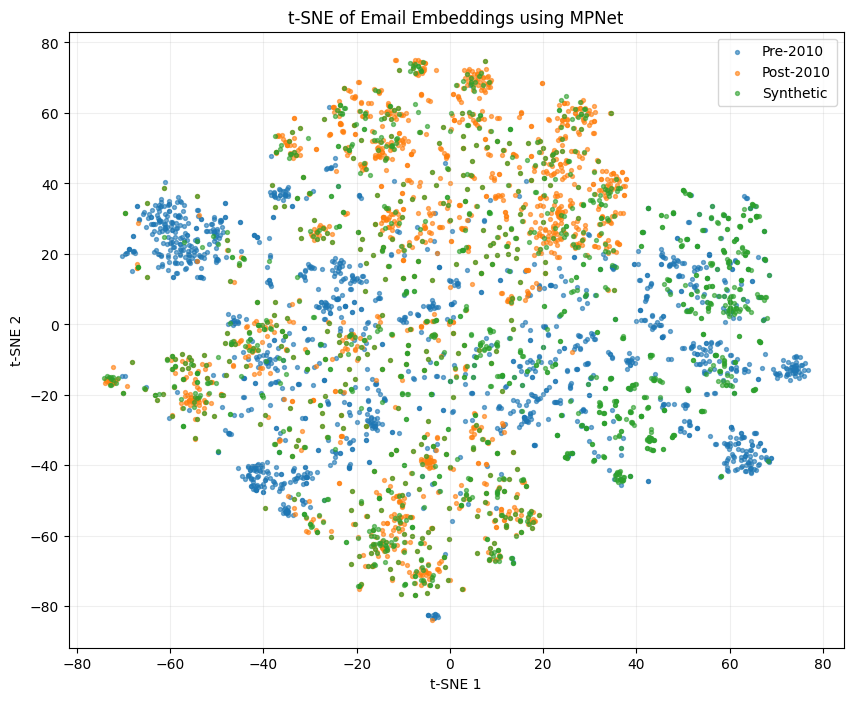

In [ ]:
plt.figure(figsize=(10, 8))

datasets = viz_df["dataset_name"].unique()
colors = ["tab:blue", "tab:orange", "tab:green"]  # 3 datasets

for ds_name, color in zip(datasets, colors):
    subset = viz_df[viz_df["dataset_name"] == ds_name]
    plt.scatter(
        subset["tsne_x"],
        subset["tsne_y"],
        s=8,
        alpha=0.6,
        label=ds_name,
        c=color,
    )

plt.title("t-SNE of Email Embeddings using MPNet")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


In [ ]:
out_path = Path(DATA_DIR) / "tsne_embeddings_prepostsynthetic.csv"
viz_df.to_csv(out_path, index=False)
print("Saved t-SNE dataframe to:", out_path)


Saved t-SNE dataframe to: /content/drive/MyDrive/COSC 4371 - Security Analytics/Adversial Machine Learning - Phishing Email Classifier/Datasets/tsne_embeddings_prepostsynthetic.csv


<h2 style="border-bottom:3px solid #64748b; padding-bottom:4px;">
🧷 Step 8 – Pairwise comparisons & Real vs Synthetic view
</h2>

<p>
Finally, we generate focused plots to compare datasets <strong>two at a time</strong>:
</p>

<ul>
  <li><strong>Pre-2010 vs Post-2010</strong> – temporal drift within real emails.</li>
  <li><strong>Pre-2010 vs Synthetic</strong> – how early real emails differ from LLM-generated ones.</li>
  <li><strong>Post-2010 vs Synthetic</strong> – how modern real emails compare to synthetic content.</li>
</ul>

<p>
We also overlay all three in a single <em>“Real (Pre+Post) vs Synthetic”</em> figure to see:
</p>

<ul>
  <li>Where synthetic emails overlap with the authentic clusters.</li>
  <li>Where they diverge, indicating potential distribution shift.</li>
</ul>

<p>
Together, these views give an intuitive picture of how close the synthetic dataset is to real email distributions in the MPNet embedding space.
</p>


In [ ]:
# Fixed colors for all plots
DATASET_COLORS = {
    "Pre-2010": "tab:blue",
    "Post-2010": "tab:orange",
    "Synthetic": "tab:green",
}

def plot_pairwise_datasets(viz_df, dataset_names, title=None):
    """
    dataset_names: list like ["Pre-2010", "Post-2010"]
    """
    subset = viz_df[viz_df["dataset_name"].isin(dataset_names)].copy()

    plt.figure(figsize=(8, 6))

    for ds_name in dataset_names:
        ds_subset = subset[subset["dataset_name"] == ds_name]
        if ds_subset.empty:
            continue

        plt.scatter(
            ds_subset["tsne_x"],
            ds_subset["tsne_y"],
            s=10,
            alpha=0.7,
            label=ds_name,
            c=DATASET_COLORS[ds_name],   # <-- fixed color here
        )

    if title is None:
        title = "t-SNE: " + " vs ".join(dataset_names)

    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


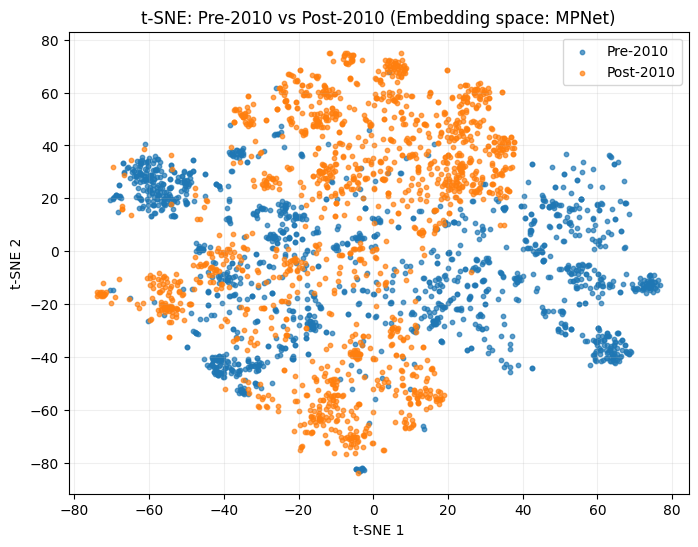

In [ ]:
plot_pairwise_datasets(
    viz_df,
    ["Pre-2010", "Post-2010"],
    title="t-SNE: Pre-2010 vs Post-2010 (Embedding space: MPNet)"
)


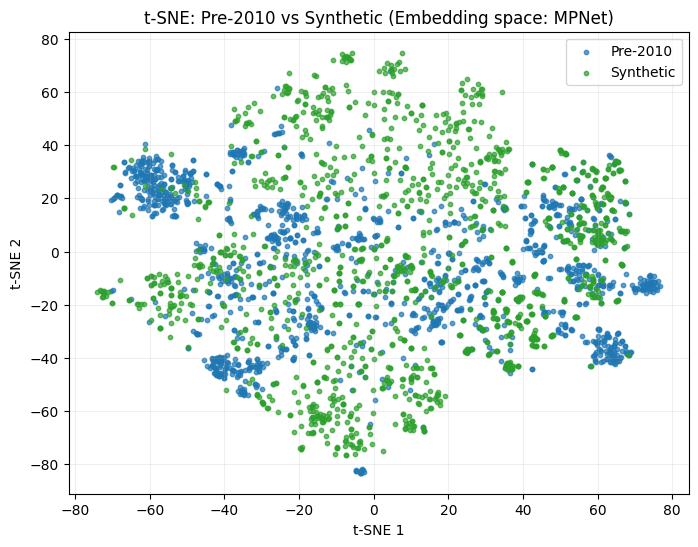

In [ ]:
plot_pairwise_datasets(
    viz_df,
    ["Pre-2010", "Synthetic"],
    title="t-SNE: Pre-2010 vs Synthetic (Embedding space: MPNet)"
)


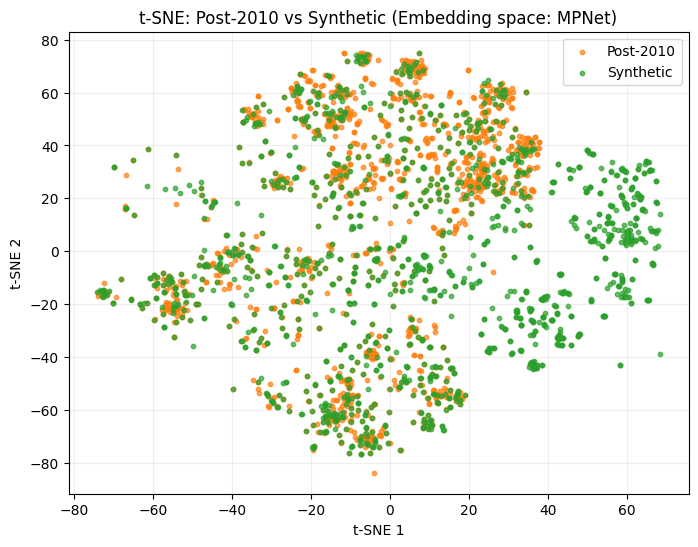

In [ ]:
plot_pairwise_datasets(
    viz_df,
    ["Post-2010", "Synthetic"],
    title="t-SNE: Post-2010 vs Synthetic (Embedding space: MPNet)"
)


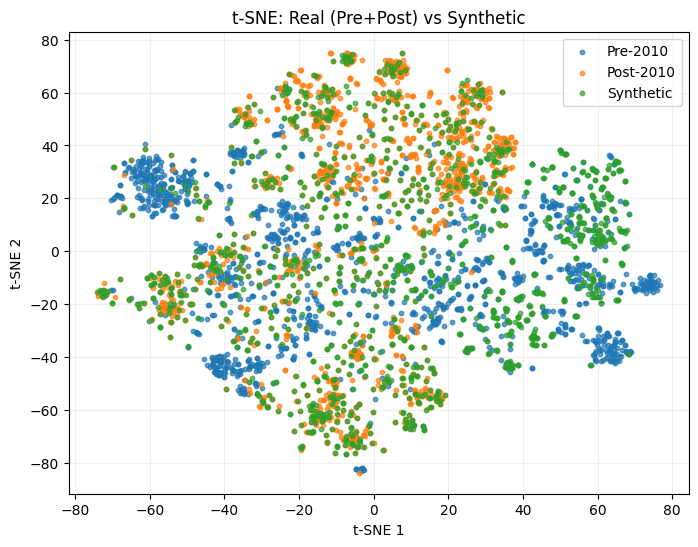

In [ ]:
plt.figure(figsize=(8, 6))

for ds_name in ["Pre-2010", "Post-2010", "Synthetic"]:
    subset = viz_df[viz_df["dataset_name"] == ds_name]
    plt.scatter(
        subset["tsne_x"],
        subset["tsne_y"],
        s=10,
        alpha=0.7,
        label=ds_name,
        c=DATASET_COLORS[ds_name],
    )

plt.title("t-SNE: Real (Pre+Post) vs Synthetic")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
